# Introduction

As you saw in the previous notebook on Vanilla GAN, we don't have any control over the digits that are generated. However we can force the generator to generate a particular digit by giving the labels as the input to the generator. As you will see, we need to give these labels to both the generator and discrminator during the training process.

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

/home/abhishek/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# DataSet

Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


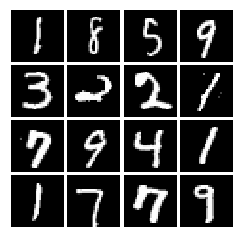

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=True)

# show a batch
show_images(mnist.train.next_batch(16)[0])

### Random Noise

In [3]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    return tf.random_uniform([batch_size, dim], -1, 1)

In [4]:
def sample_labels(batch_size, dim):
    """Generate one hot random labels.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing one-hot labels with shape [batch_size, dim]
    """
    labels = tf.random_uniform([batch_size, dim], 0, 1)
    return tf.one_hot(tf.argmax(labels, axis=1), dim)

### Discrmiminator

In [5]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images along with its labels, shape [batch_size, 784 + 10]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        layer_1 = tf.layers.dense(x, 256, tf.nn.leaky_relu, name="layer_1")
        layer_2 = tf.layers.dense(layer_1, 256, tf.nn.leaky_relu, name="layer_2")
        logits = tf.layers.dense(layer_2, 1, name="logit")
        return logits

### Generator

In [6]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim + label_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        layer_1 = tf.layers.dense(z, 1024, tf.nn.relu, name="layer_1")
        layer_2 = tf.layers.dense(layer_1, 1024, tf.nn.relu, name="layer_2")
        img = tf.layers.dense(layer_2, 784, tf.nn.tanh, name="image")
        return img

### GAN loss

In [7]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    ones_labels_d = tf.ones_like(logits_real) 
    zeros_labels_d = tf.zeros_like(logits_fake)
    
    ones_labels_g = tf.ones_like(logits_fake)
    
    real_data_predictions = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=ones_labels_d)
    fake_data_predictions = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=zeros_labels_d)
    D_loss = tf.reduce_mean(real_data_predictions) + tf.reduce_mean(fake_data_predictions)
    
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=ones_labels_g))
    return D_loss, G_loss

### Optimizers

In [8]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

    return D_solver, G_solver

### Putting it all together

In [9]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96
labels_dim = 10

# placeholder for images from the training dataset
x_image = tf.placeholder(tf.float32, [None, 784])
# scale images to be -1 to 1
x_image_preprocess = preprocess_img(x_image)
# placeholders for labels
x_label = tf.placeholder(tf.float32, [None, labels_dim])
# concate labels and images
x = tf.concat((x_image_preprocess, x_label), axis=1)

# random image_noise fed into our generator
z_image = sample_noise(batch_size, noise_dim)
# random label_nose fed into the generator
z_label = sample_labels(batch_size, labels_dim)
# concat image and noise
z = tf.concat((z_image, z_label), axis=1)

# generated images
G_sample = generator(z)
# concat generated images with fake labels
G_sample_with_labels = tf.concat((G_sample, z_label), axis=1)

with tf.variable_scope("") as scope:
    logits_real = discriminator(x)
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample_with_labels)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

### Run a GAN

In [10]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(deprocess_img(samples[:16]))
            plt.show()
            print()
        # run a batch of data through the network
        minibatch_x, minibatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x_image: minibatch_x,
                                                                     x_label: minibatch_y})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(deprocess_img(samples[:16]))
    plt.show()

# Training

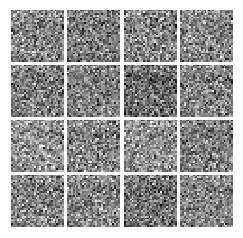


Iter: 0, D: 1.451, G:0.7553
Iter: 50, D: 0.9123, G:1.527
Iter: 100, D: 1.171, G:1.605
Iter: 150, D: 1.233, G:1.324
Iter: 200, D: 1.005, G:1.148


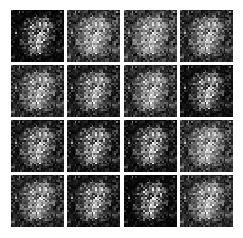


Iter: 250, D: 0.6144, G:1.622
Iter: 300, D: 0.792, G:1.348
Iter: 350, D: 1.143, G:1.466
Iter: 400, D: 1.094, G:1.395
Iter: 450, D: 0.8837, G:2.092


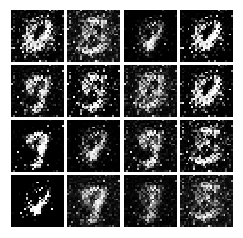


Iter: 500, D: 1.051, G:4.684
Iter: 550, D: 1.401, G:0.9716
Iter: 600, D: 0.767, G:1.361
Iter: 650, D: 0.893, G:1.621
Iter: 700, D: 0.8419, G:2.142


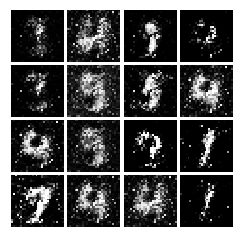


Iter: 750, D: 1.069, G:1.195
Iter: 800, D: 1.05, G:1.262
Iter: 850, D: 1.134, G:2.148
Iter: 900, D: 1.012, G:1.066
Iter: 950, D: 1.011, G:1.299


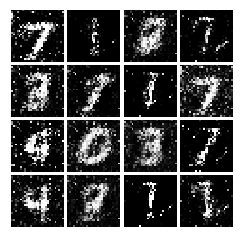


Iter: 1000, D: 1.193, G:1.617
Iter: 1050, D: 1.186, G:1.244
Iter: 1100, D: 1.213, G:1.811
Iter: 1150, D: 1.174, G:0.9
Iter: 1200, D: 1.044, G:1.098


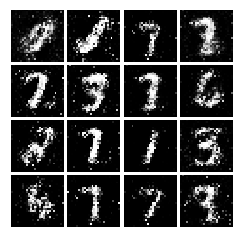


Iter: 1250, D: 1.313, G:1.264
Iter: 1300, D: 1.272, G:1.644
Iter: 1350, D: 1.229, G:0.964
Iter: 1400, D: 1.243, G:1.147
Iter: 1450, D: 1.13, G:1.176


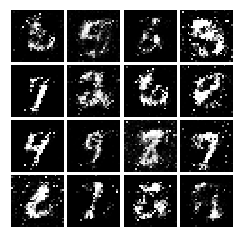


Iter: 1500, D: 1.339, G:1.502
Iter: 1550, D: 1.2, G:1.107
Iter: 1600, D: 1.151, G:0.9949
Iter: 1650, D: 1.312, G:0.9654
Iter: 1700, D: 1.222, G:0.9804


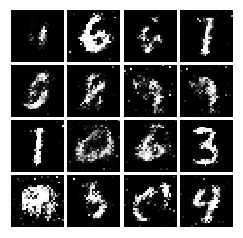


Iter: 1750, D: 1.246, G:1.111
Iter: 1800, D: 1.24, G:0.9269
Iter: 1850, D: 1.347, G:1.111
Iter: 1900, D: 1.323, G:0.908
Iter: 1950, D: 1.351, G:0.9524


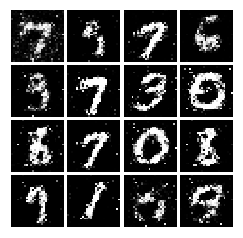


Iter: 2000, D: 1.264, G:0.9149
Iter: 2050, D: 1.273, G:0.7197
Iter: 2100, D: 1.273, G:0.9331
Iter: 2150, D: 1.362, G:0.8866
Iter: 2200, D: 1.28, G:0.9462


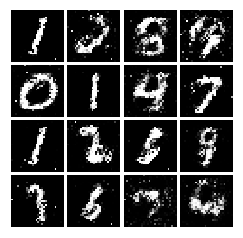


Iter: 2250, D: 1.285, G:0.9895
Iter: 2300, D: 1.313, G:0.9228
Iter: 2350, D: 1.34, G:0.8496
Iter: 2400, D: 1.328, G:1.063
Iter: 2450, D: 1.279, G:1.03


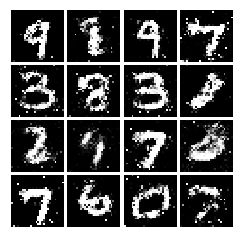


Iter: 2500, D: 1.323, G:0.9714
Iter: 2550, D: 1.352, G:0.8616
Iter: 2600, D: 1.239, G:0.9555
Iter: 2650, D: 1.283, G:0.7928
Iter: 2700, D: 1.26, G:0.9631


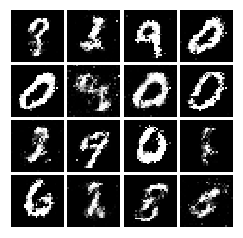


Iter: 2750, D: 1.361, G:0.9022
Iter: 2800, D: 1.295, G:0.842
Iter: 2850, D: 1.34, G:0.8967
Iter: 2900, D: 1.25, G:0.864
Iter: 2950, D: 1.306, G:0.9193


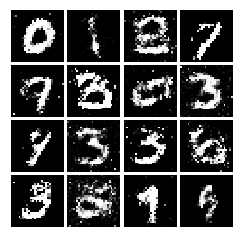


Iter: 3000, D: 1.266, G:0.9453
Iter: 3050, D: 1.312, G:0.9613
Iter: 3100, D: 1.308, G:0.8417
Iter: 3150, D: 1.359, G:0.8889
Iter: 3200, D: 1.252, G:0.9915


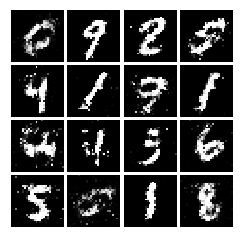


Iter: 3250, D: 1.345, G:0.9479
Iter: 3300, D: 1.328, G:0.8876
Iter: 3350, D: 1.371, G:1.159
Iter: 3400, D: 1.287, G:0.8428
Iter: 3450, D: 1.335, G:0.8642


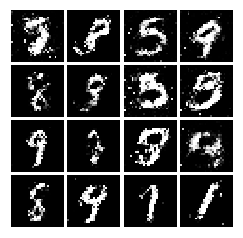


Iter: 3500, D: 1.352, G:1.027
Iter: 3550, D: 1.292, G:0.8262
Iter: 3600, D: 1.364, G:1.068
Iter: 3650, D: 1.342, G:1.014
Iter: 3700, D: 1.321, G:0.8961


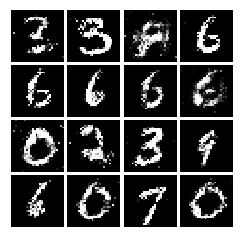


Iter: 3750, D: 1.332, G:0.7634
Iter: 3800, D: 1.261, G:0.8999
Iter: 3850, D: 1.258, G:0.9482
Iter: 3900, D: 1.302, G:0.7761
Iter: 3950, D: 1.366, G:0.684


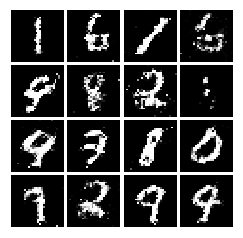


Iter: 4000, D: 1.285, G:0.916
Iter: 4050, D: 1.315, G:0.8125
Iter: 4100, D: 1.397, G:1.124
Iter: 4150, D: 1.378, G:0.9205
Iter: 4200, D: 1.298, G:0.7027


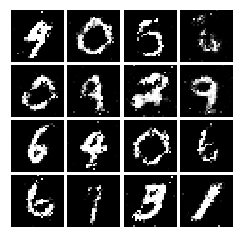


Iter: 4250, D: 1.325, G:0.7877
Final images


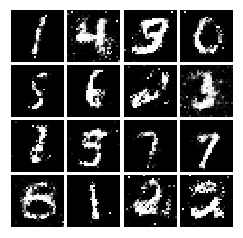

In [11]:
sess = get_session()
sess.run(tf.global_variables_initializer())
run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Conclusion of training 

When I trained the network without preprocessing the image, it seems that images are put on the top of some white noise. 

# Showing that Vanila Conditional GAN is able to generate the similar looking images by using the labels

In [12]:
def get_fixed_labels(batch_size, label_num):
    """
    Generate the labels to use in the Conditional GAN
    """
    labels = np.zeros((batch_size, 10))
    labels[np.arange(batch_size), label_num] = 1
    return labels

### Generating samples similar to digit $7$

** In the below code, I am using the trick that you can pass values to a tensorflow variables**

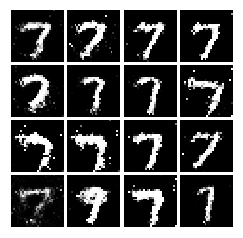

In [13]:
samples = sess.run(G_sample, feed_dict={z_label:get_fixed_labels(batch_size, 7)})
fig = show_images(samples[:16])
plt.show()

** Conclusion:** There are confusions between $7$ and $9$.

### Generating samples similar to digit $3$

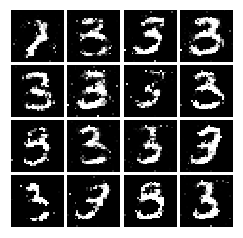

In [14]:
samples = sess.run(G_sample, feed_dict={z_label:get_fixed_labels(batch_size, 3)})
fig = show_images(samples[:16])
plt.show()

### Why does it work?

In the input of the discriminator, we send the both the original images and labels. So Discrminator figrues out that there is a correlation between labels and images. To fool the discrminator, the generator also has to follow this correlation. 